# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
import scipy

mpl.rcParams['axes.linewidth'] = 2

# Paths

In [2]:
fig5_path = os.getcwd()
figures_path = str(Path(fig5_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_19_2020/Radiologists Analysis/'

# Plot params 

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject loop 

In [6]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

90 files, 15 folders
14 subjects


In [7]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

## Calculate mean and errorr bars 

In [6]:
alldata_trimed = pd.DataFrame()
alldata = pd.DataFrame(columns=['SUBJECT', 'RUNNING_MEAN'])

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    subjectdata_temp['Running_Mean'] = subjectdata_complete['Running_Mean'].dropna()
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    
    alldata_trimed.loc[row,'SUBJECT'] = subject
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(subjectdata_temp['Running_Mean'])
    
    alldata_trimed.loc[row, 'AVERAGE_MEAN'] = mean
    alldata_trimed.loc[row, 'MEAN_SEM_LOW'] = sem_low
    alldata_trimed.loc[row, 'MEAN_SEM_UP'] = sem_up
    
    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    

    row += 1
    

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


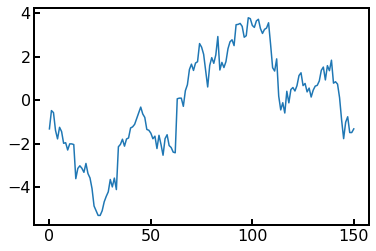

In [7]:
plt.plot(subjectdata_complete['Running_Mean'])

In [8]:
alldata = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    alldata[subject] = subjectdata_complete['Running_Mean'].dropna()
        


S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


In [9]:
for row in range(len(alldata)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata.iloc[row, 0:nSubjects])
    alldata.loc[row, 'MEAN'] = mean
    alldata.loc[row, 'SEM_LOW'] = sem_low
    alldata.loc[row, 'SEM_UP'] = sem_up

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


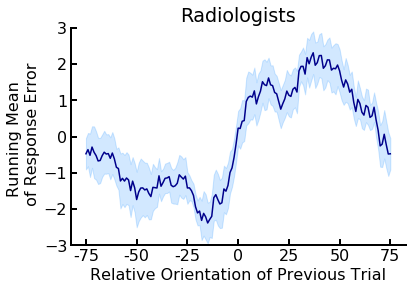

In [10]:
plt.plot(alldata['MEAN'], color='darkblue')
plt.fill_between(range(len(alldata)), alldata['SEM_LOW'], alldata['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Running Mean \n of Response Error')
plt.xlabel('Relative Orientation of Previous Trial')
plt.ylim([-3, 3])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks(np.arange(0, 151, 25), ('-75', '-50', '-25', '0', '25', '50', '75'))
sns.despine()
plt.title('Radiologists')
plt.savefig('AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

# Calculating running mean w/ diff step 

In [4]:
def getRunningMean(stimuli_diff, filtered_responseError, halfway =73, step = 20):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

In [12]:
test = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)

In [13]:
RM, xvals = getRunningMean(test['Stim_diff'], test['responseError'], step = 20)

In [5]:
## IMPORTANT PARAMETERS:
step = 20

alldata_20 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_20[subject] = RM
        
for row in range(len(alldata_20)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_20.iloc[row, 0:nSubjects])
    alldata_20.loc[row, 'MEAN'] = mean
    alldata_20.loc[row, 'SEM_LOW'] = sem_low
    alldata_20.loc[row, 'SEM_UP'] = sem_up

NameError: name 'subject_names' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


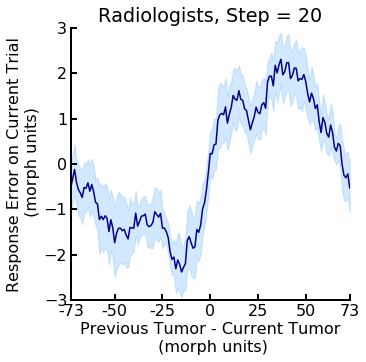

In [15]:
step = 20

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_20['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_20['SEM_LOW'], alldata_20['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [16]:
## IMPORTANT PARAMETERS:
step = 25

alldata_25 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_25[subject] = RM
        
for row in range(len(alldata_25)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_25.iloc[row, 0:nSubjects])
    alldata_25.loc[row, 'MEAN'] = mean
    alldata_25.loc[row, 'SEM_LOW'] = sem_low
    alldata_25.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


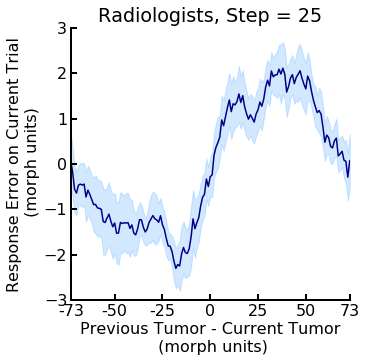

In [17]:
step = 25

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_25['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_25['SEM_LOW'], alldata_25['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [8]:
## IMPORTANT PARAMETERS:
step = 30

alldata_30 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_30[subject] = RM
        
for row in range(len(alldata_30)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_30.iloc[row, 0:nSubjects])
    alldata_30.loc[row, 'MEAN'] = mean
    alldata_30.loc[row, 'SEM_LOW'] = sem_low
    alldata_30.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


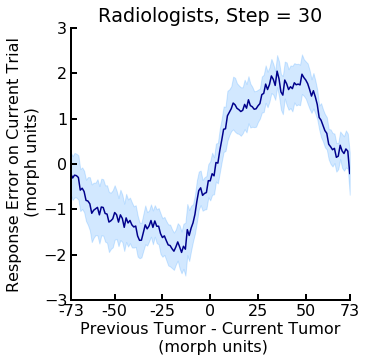

In [11]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [20]:
## IMPORTANT PARAMETERS:
step = 35

alldata_35 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_35[subject] = RM
        
for row in range(len(alldata_35)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_35.iloc[row, 0:nSubjects])
    alldata_35.loc[row, 'MEAN'] = mean
    alldata_35.loc[row, 'SEM_LOW'] = sem_low
    alldata_35.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


In [10]:
step = 35

plt.figure(figsize=(5, 5))
plt.plot(xvals,alldata_35['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_35['SEM_LOW'], alldata_35['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

NameError: name 'alldata_35' is not defined

<Figure size 360x360 with 0 Axes>

# Calculate average fit 

In [12]:
fitting_all_data = pd.DataFrame()
a = pd.DataFrame()
a['Stim_diff'] = np.arange(-74, 74, 1)
for subject in subject_names:
    subjectdata_nonan = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    

    # select the columns we care about
    # drop the NaNs
    
    selected_cols = subjectdata[['DoVM_values', 'Stim_diff']].dropna()
    subjectdata_nonan['DoVM_values'] = selected_cols['DoVM_values']
    
    selected_cols.sort_values(by='Stim_diff', inplace=True)
    grouped = selected_cols.groupby('Stim_diff', as_index=False).mean()
    
    
    
    for i in range(len(grouped)):
        stim_diff = grouped.loc[i, 'Stim_diff']
        
        # find index in a where stim_diff is that one
        index_stim_diff = np.where(a['Stim_diff'] == stim_diff)
        a.loc[int(index_stim_diff[0]), subject] = grouped.loc[i, 'DoVM_values']
        
        
        
    #     plt.figure(figsize=(5, 5))

#     plt.plot(selected_cols['Stim_diff'], selected_cols['DoVM_values'])

    fitting_all_data[subject] = grouped['DoVM_values']


# mean_fit_all, ci_fit_low_all, ci_fit_up_all = mean_confidence_interval.mean_sem(fitting_all_data['MEAN'])



In [13]:
for row in range(len(a)): # let's go calculating row by row
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(a.iloc[row, 1:nSubjects+1])
    a.loc[row, 'MEAN'] = mean
    a.loc[row, 'SEM_LOW'] = sem_low
    a.loc[row, 'SEM_UP'] = sem_up

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py:914: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

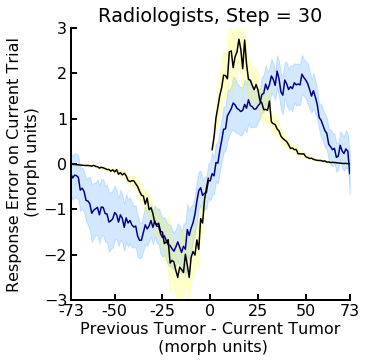

In [15]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)


# fit
plt.plot(a['Stim_diff'], a['MEAN'], color='black')
plt.fill_between(a['Stim_diff'], a['SEM_LOW'], a['SEM_UP'], facecolor="orange", color='yellow', alpha=0.2)



plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [16]:
a

,Stim_diff,S1,S3,S4,S6,S7,S8,s9,s10,s11,s12,s13,s14,s15,MEAN,SEM_LOW,SEM_UP
0,-74,-0.000276,-0.001425,-0.004880,NaN,-0.000223,-0.005227,-0.001855,NaN,NaN,NaN,0.000062,NaN,-0.005630,-0.002432,-0.001575,-0.003289
1,-73,-0.000558,NaN,-0.009804,-0.000074,-0.000450,-0.010508,-0.003726,-0.007586,-0.000229,-0.010265,NaN,-0.014074,-0.011309,-0.006235,-0.004633,-0.007837
2,-72,-0.000851,-0.004325,NaN,-0.000112,NaN,-0.015900,-0.005630,-0.011462,-0.000350,-0.015510,0.000192,-0.021265,NaN,-0.007521,-0.005021,-0.010022
3,-71,-0.001160,-0.005826,-0.019953,-0.000153,-0.000935,-0.021461,-0.007584,NaN,NaN,-0.020892,0.000262,-0.028644,-0.023017,-0.011760,-0.008433,-0.015088
4,-70,-0.001493,-0.007378,-0.025269,NaN,-0.001203,-0.027248,NaN,-0.019552,-0.000614,-0.026459,0.000337,-0.036276,-0.029149,-0.015846,-0.011662,-0.020030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,69,0.001855,0.008996,NaN,0.000244,0.001495,0.033326,0.011710,0.023838,0.000763,0.032259,-0.000419,NaN,0.035540,0.013601,0.018045,0.009157
144,70,0.001493,0.007378,0.025269,0.000197,0.001203,NaN,0.009604,NaN,0.000614,NaN,-0.000337,0.036276,0.029149,0.011084,0.015464,0.006705
145,71,NaN,NaN,0.019953,NaN,0.000935,NaN,NaN,0.015439,NaN,0.020892,-0.000262,NaN,0.023017,0.013329,0.017563,0.009095
146,72,0.000851,0.004325,0.014813,0.000112,0.000686,0.015900,NaN,NaN,NaN,NaN,-0.000192,0.021265,0.017088,0.008316,0.011236,0.005396
